In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import torch

from mucstpy.utils import (read_10x_visium, data_augmentation, construction_interaction, add_contrastive_label, get_feature)
from mucstpy.image_feature import ImageFeature, image_crop
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
os.environ['R_HOME'] = 'C:/Program Files/R/R-4.3.1'

### Please change data path to your dir_path here

In [3]:
section = '151673'

data_path = 'D:/st_projects/data/DLPFC'
# load 10 X DLPFC dataset as benchmark
adata = read_10x_visium(path=os.path.join(data_path, section), count_file=section + '_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()
adata.obs['ground_truth'] = pd.read_csv(os.path.join(data_path, section) + '/' + section + '_truth.txt', sep='\t', header=None, index_col=0)

cluster_num = pd.get_dummies(adata.obs['ground_truth']).shape[1]
cluster_num

7

In [4]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata = adata[:, adata.var['total_counts'] > 100]
adata.raw = adata
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)

sc.pp.filter_genes(adata, min_cells=1)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)
# sc.pp.scale(adata)

In [5]:
save_path = 'results'
save_path_image_crop = Path(os.path.join(save_path, 'image_crop', f'{section}'))
save_path_image_crop.mkdir(parents=True, exist_ok=True)

adata = image_crop(adata, crop_size=112, save_path=save_path_image_crop, verbose=False)
adata = ImageFeature(adata, pca_components=200, verbose=True, seeds=2023).extract_image_features()
adata

Tiling Image: 100%|██████████ [ time left: 00:00 ]
Extract image feature: 100%|██████████ [ time left: 00:00 ]


The image feature is added to adata.obsm['Image_Feature']
The pca result of image features is added to adata.obsm['image_feat_pca']


AnnData object with n_obs × n_vars = 3639 × 11353
    obs: 'in_tissue', 'array_row', 'array_col', 'image_col', 'image_row', 'ground_truth', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'slice_path'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'image_feature', 'aug_image_feature1', 'aug_image_feature2', 'image_feat_pca'

### Calculatet the spatial network, where edges are weighted by morphological similarity

In [6]:
from sklearn.metrics import pairwise_distances

construction_interaction(adata, n_neighbor=6)
adj = adata.obsm['adj']

morphological_similarity = 1 - pairwise_distances(np.array(adata.obsm['image_feat_pca']), metric='cosine')
morphological_similarity[morphological_similarity < 0] = 0

adj_spatial_mor = adj * morphological_similarity
adata.obsm['mor_adj'] = adj_spatial_mor

### Plot the network for all spots

Maximum weight: 1.0



(2697.7, 11460.3, -12041.35, -1979.65)

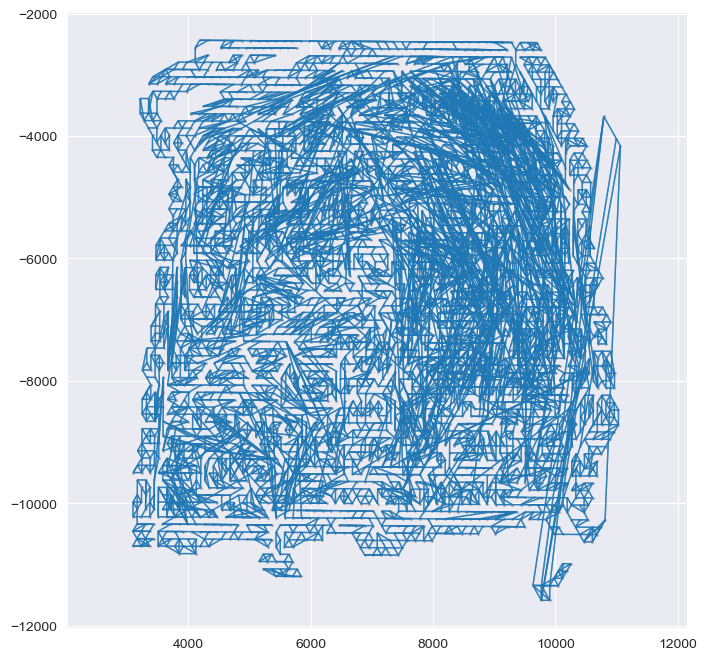

In [7]:
from mucstpy.utils import plot_graph_weights
from scipy import sparse
import matplotlib.pyplot as plt

position = adata.obsm['spatial'].copy()
position[:, 1] = -position[:, 1]
interaction = np.zeros_like(morphological_similarity)
for i in range(morphological_similarity.shape[0]):
    vec = morphological_similarity[i, :]
    distance = vec.argsort()[:: -1]
    for t in range(1, 3 + 1):
        y = distance[t]
        interaction[i, y] = 1
    
interaction = interaction + interaction.T
interaction = np.where(interaction > 1, 1, interaction)

plot_graph_weights(position, sparse.csr_matrix(interaction), max_weight=1, markersize=1, figsize=(8, 8))
ax = plt.gca()
ax.axis('equal')

In [8]:
data_augmentation(adata)

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
device

device(type='cuda')

In [10]:
from mucstpy.MuCST import train_model

add_contrastive_label(adata)
get_feature(adata)

gene_dims=[adata.shape[1], 64]
img_dims=[adata.obsm['image_feature'].shape[1], 64]
project_dims=[64, 32, 16]

train_model(adata, gene_dims=gene_dims, img_dims=img_dims, proj_dims=project_dims, lamb1=0.3, device=device)

Begin to train MuCST...


# Epoch 1499, loss: 0.990, g2g_loss: 0.364, gene_recon: 0.953, image_recon: 0.004:  97%|█████████▋| 1500/1550 [00:28<00:00, 53.79it/s]

# Epoch 1500, loss: 19.928, g2g_loss: 0.364, gene_recon: 0.953, image_recon: 0.004
Init finished, start contrastive learning part


# Epoch 1549, loss: 18.900, g2i_loss: 8.975, g2g_loss: 0.552, i2i_loss: 8.892, gene_recon: 0.974, image_recon: 0.012: 100%|██████████| 1550/1550 [01:27<00:00, 17.77it/s] 


Optimization of MuCST finished


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


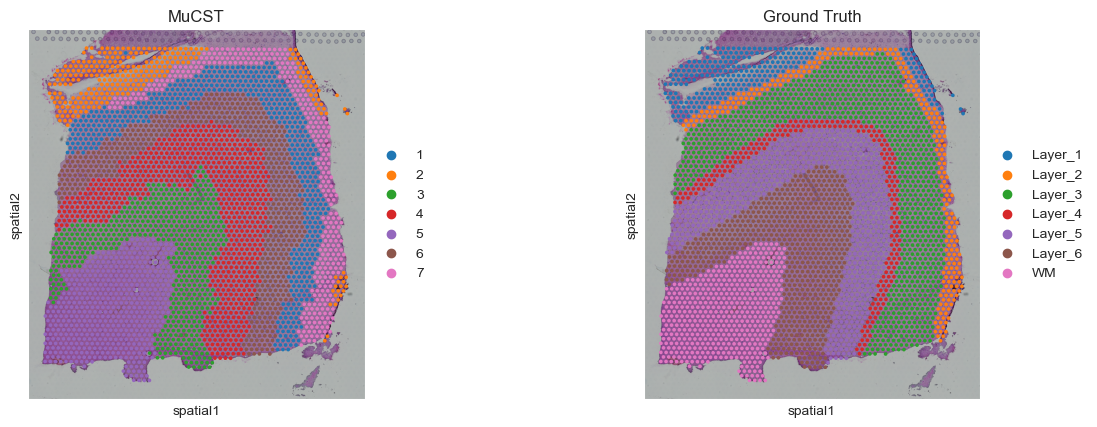

In [11]:
from mucstpy.utils import mclust_R, refine_label

tool = 'mclust'
radius = 10

mclust_R(adata, used_obsm='fusion_pca', num_cluster=cluster_num)
new_type = refine_label(adata, radius, key='mclust')
adata.obs['domain'] = new_type

adata_full = adata[~pd.isnull(adata.obs['ground_truth'])]
sc.pl.spatial(adata_full, color=['domain', 'ground_truth'], title=['MuCST', 'Ground Truth'])

In [12]:
# scale the expression to [0, 1]
def relative_func(expres):
    #expres: an array counts expression for a gene
    maxd = np.max(expres) - np.min(expres)
    min_exp = np.min(expres)
    rexpr = (expres - min_exp) / maxd
    return rexpr

In [13]:
raw_exp = adata.X.A
raw_exp = pd.DataFrame(raw_exp)
rec_exp = pd.DataFrame(adata.obsm['rec_feature'])

raw_exp.index = adata.obs.index
raw_exp.columns = adata.var.index
rec_exp.index = adata.obs.index
rec_exp.columns = adata.var.index

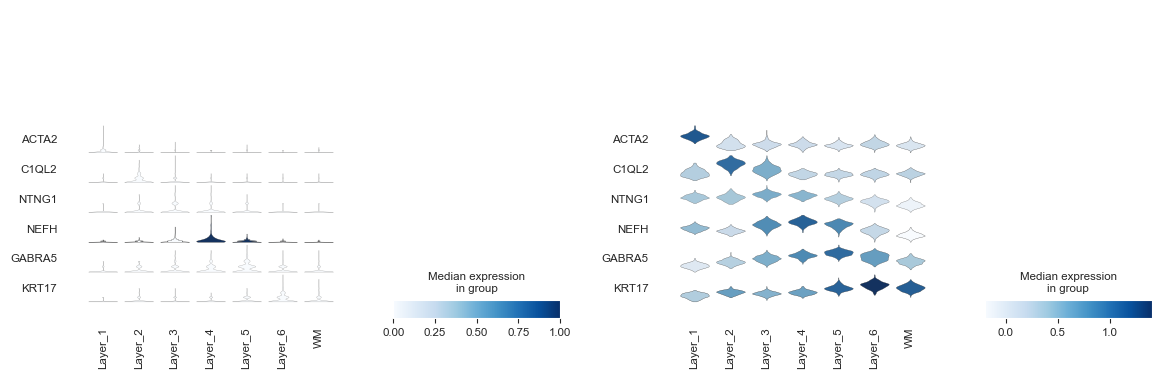

In [14]:
plot_gene = ['KRT17', 'GABRA5', 'NEFH', 'NTNG1', 'C1QL2', 'ACTA2'][::-1]
# marker_genes = ['S100B', 'KRT17', 'GABRA5', 'NEFH', 'NTNG1', 'C1QL2', 'ACTA2' ]
# marker_genes = marker_genes[::-1]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
sc.pl.stacked_violin(adata, var_names=plot_gene, groupby='ground_truth', swap_axes=True, ax=axs[0], show=False)
sc.pl.stacked_violin(adata, var_names=plot_gene, groupby='ground_truth', layer='My_ReX', swap_axes=True, ax=axs[1], show=False)
# plt.savefig('images/dlpfc_raw_enhance_gene_stacked_violin.eps', dpi=300, format='eps')
plt.show()